# 1. Working Directory and package installation

In [2]:
!python --version

Python 3.7.13


In [ ]:
%pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.3 MB/s 
     |████████████████████████████████| 63 kB 959 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from google.colab import drive
import os
import pandas as pd
import yfinance as yf
drive.mount('/content/drive/', force_remount=False)
os.chdir('/content/drive/MyDrive/BackUp_RL_CodeBase') # read files
# os.chdir('/content/drive/MyDrive/A_RL_CodeBase')
os.getcwd()

Mounted at /content/drive/


'/content/drive/MyDrive/BackUp_RL_CodeBase'

In [ ]:
class downloadYF:
    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------

        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        for tic in self.ticker_list:
            temp_df = yf.download(tic, start=self.start_date, end=self.end_date, proxy=proxy)
            temp_df["tic"] = tic
            data_df = data_df.append(temp_df)
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.columns = [
                "date",
                "open",
                "high",
                "low",
                "close",
                "adjcp",
                "volume",
                "tic",
            ]
            # use adjusted close price instead of close price
            # data_df["close"] = data_df["adjcp"]
            # # drop the adjusted close price column
            # data_df = data_df.drop(labels="adjcp", axis=1)
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)

        return data_df




# Download

In [ ]:
Universe = pd.read_excel('Input/Universe.xlsx',sheet_name='YF-Tickers')
listTicker = Universe.Ticker.tolist()
request = downloadYF(start_date = '2000-12-29',
                     end_date = '2022-04-01',
                     ticker_list = listTicker)
df = request.fetch_data()
print(df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,date,open,high,low,close,adjcp,volume,tic,day
0,2000-12-29,23.206484,23.206484,23.206484,23.206484,-3.718896,0.0,ABI.BR,4
1,2000-12-29,15.987500,16.600000,15.987500,16.500000,12.005581,3295312.0,ADS.DE,4
2,2000-12-29,32.779652,32.987118,32.592930,32.966370,18.978546,559281.0,AI.PA,4
3,2000-12-29,398.000000,402.500000,395.100006,398.600006,185.079117,173105.0,ALV.DE,4
4,2000-12-29,36.365253,36.862007,35.342529,35.342529,28.022635,1861346.0,ASML.AS,4


In [ ]:
# df.to_csv("Input/A_priceRaw.csv", index=False)

# EDA

Check the Closing price and Adjusted Close,  adjusted price is shown in colors and unadjusted in blacks.

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f216a471250>,
      dtype=object)

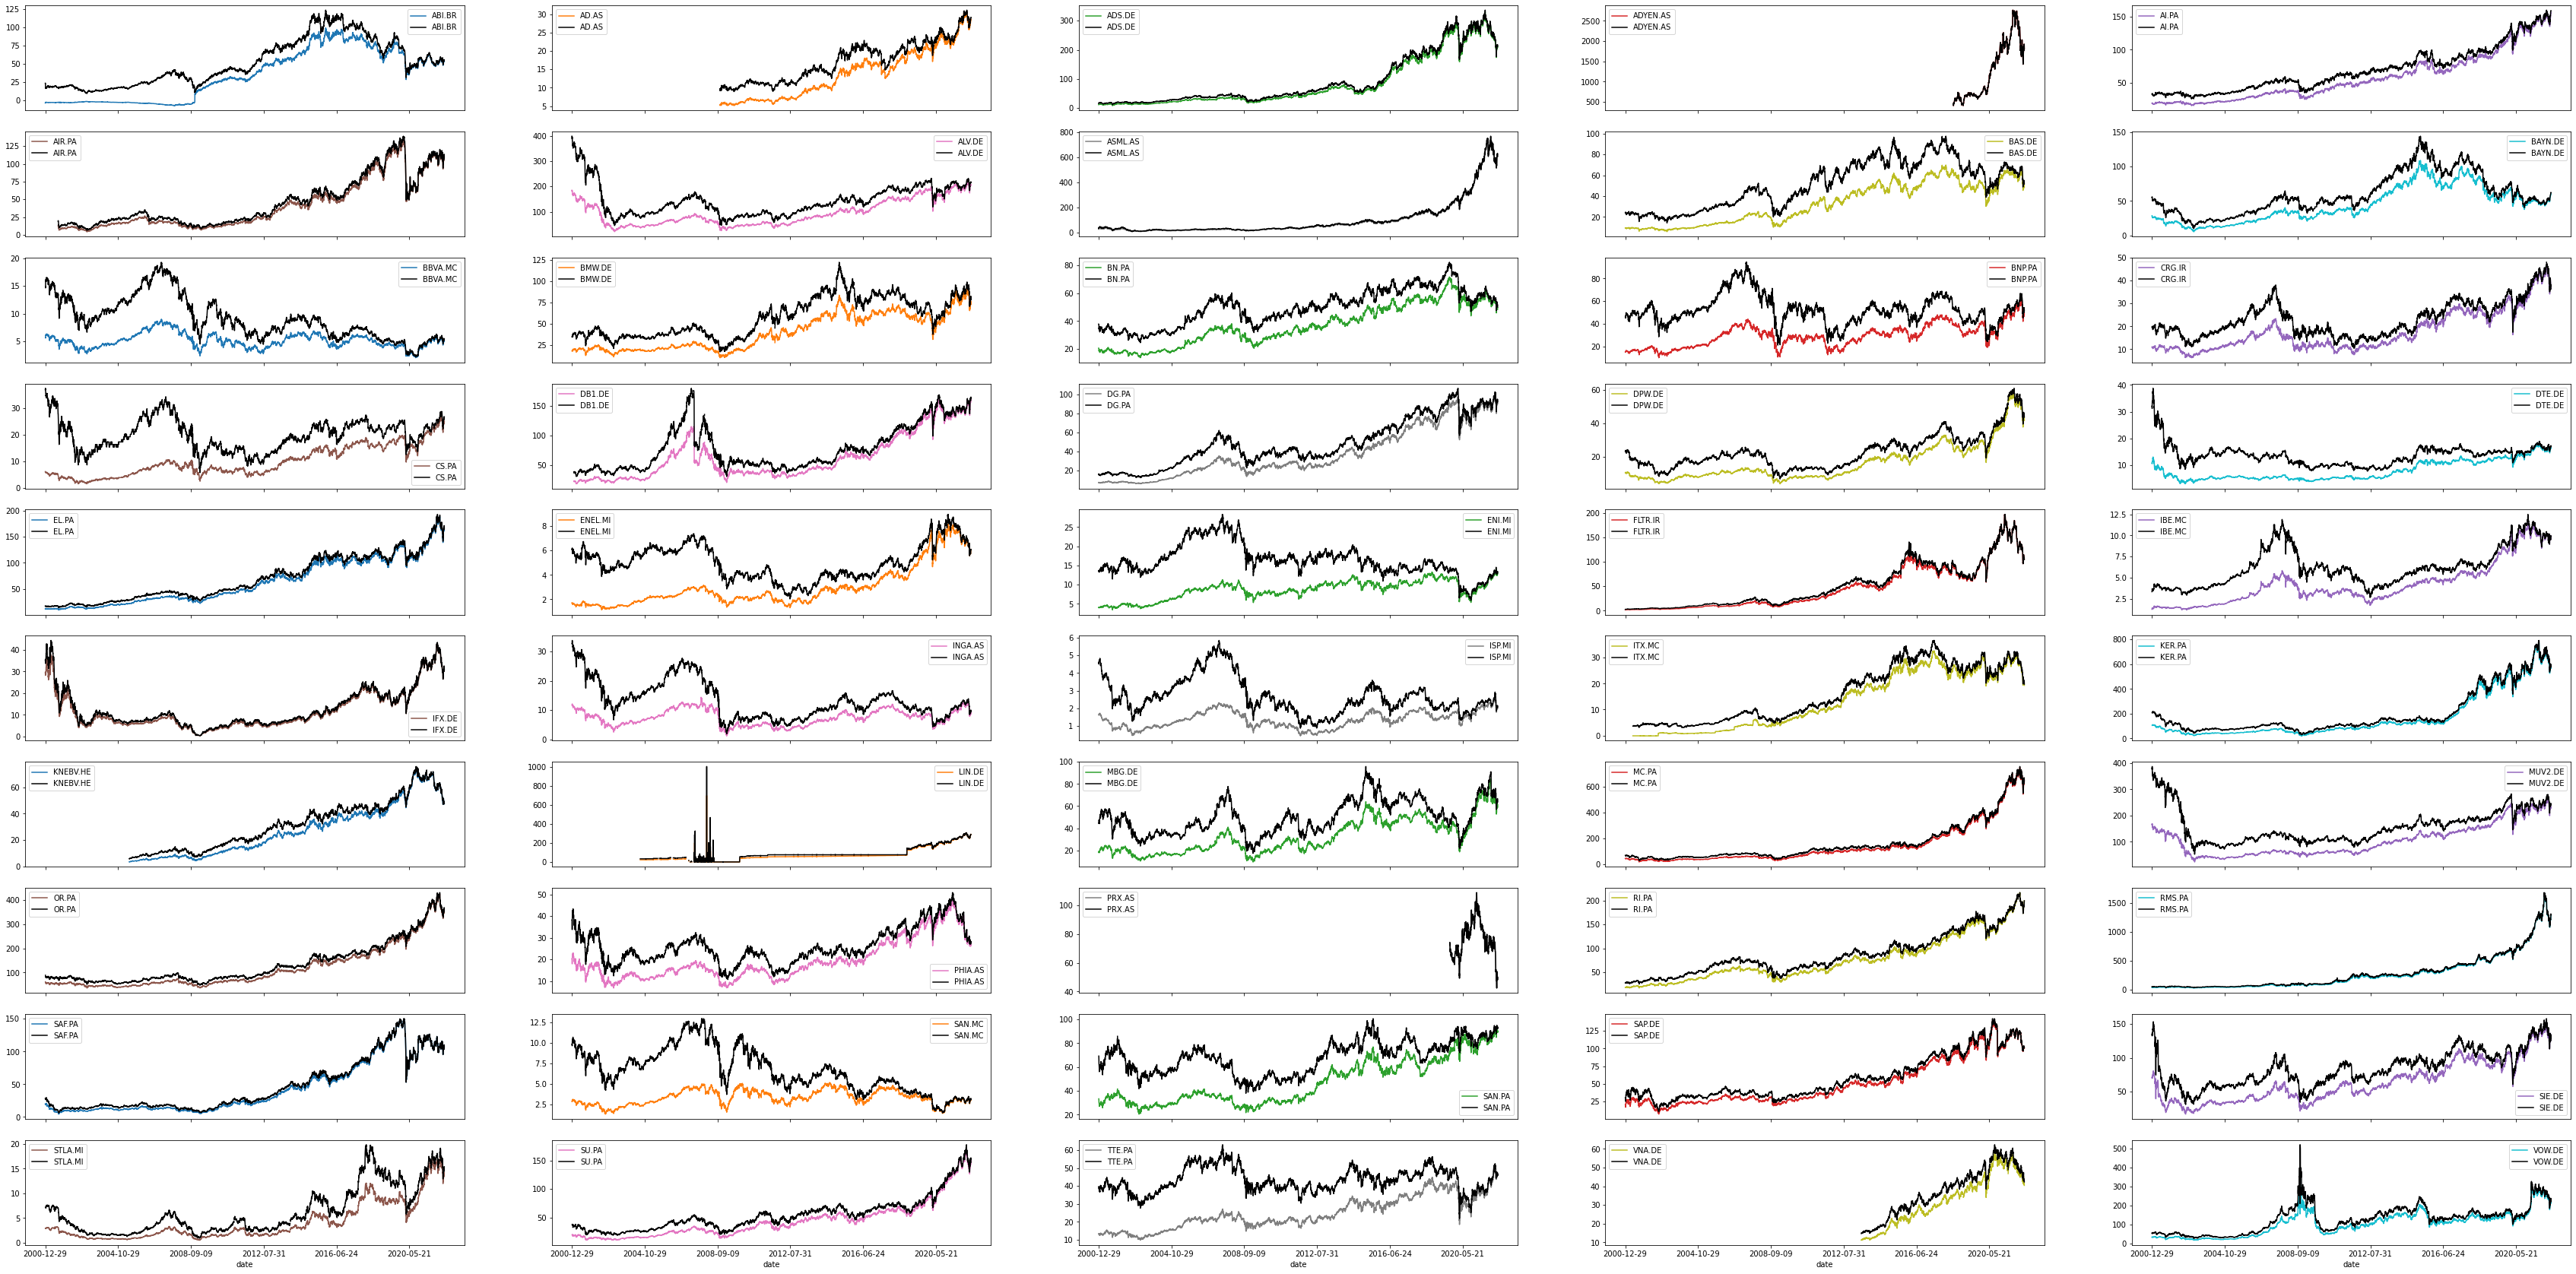

In [ ]:
pClose = df.pivot_table(index="date", columns="tic", values="close")
adjClose = df.pivot_table(index="date", columns="tic", values="adjcp")
ax = adjClose.plot(subplots=True,layout=(10,5),figsize=(60,30))
pClose.plot(subplots=True,color = 'black',layout=(10,5),figsize=(60,30),ax=ax)

We will have a look at the adjusted close from YFinance and Factset,  ClosePrice from Factset is downloaded as adjusted close.

In [ ]:
# read factset input and mapping
mapping = pd.read_excel("Input/Universe.xlsx",sheet_name ="Factset-YF-Mapping")
raw_fs_price = pd.read_excel("Input/Eurostoxx50_Adjc.xlsx",sheet_name ="Close",index_col='Date')
mappingFCYF = mapping[['Ticker','YFTicker']] # columns for mapping
# if the columns are all in the same sequence, we will rename the columns directly with YF tickers create new dataframe call rn_fs
if (raw_fs_price.columns == mappingFCYF.Ticker).all(): 
  rn_fs = raw_fs_price.copy()
  rn_fs.columns = mappingFCYF.YFTicker
# check that the mapping has been implemented correctly
# raw_fs_price.columns
# rn_fs.columns

# we sort the factset columns so that it match with the YF sequence for plotting
adjClose_fc = rn_fs.sort_index(axis=1) 
# adjClose_fc.columns
# adjClose.columns

In [ ]:
adjClose_fc.head()

YFTicker,ABI.BR,AD.AS,ADS.DE,ADYEN.AS,AI.PA,AIR.PA,ALV.DE,ASML.AS,BAS.DE,BAYN.DE,...,SAF.PA,SAN.MC,SAN.PA,SAP.DE,SIE.DE,STLA.MI,SU.PA,TTE.PA,VNA.DE,VOW.DE
Date,,,,,,,,,,,,,,,,,,,,,
12/29/2000,16.729860,17.446480,12.643474,NaN,20.031734,16.760504,156.73375,21.845663,9.845617,26.984653,...,17.156720,3.950961,35.674206,23.317125,44.246235,3.808510,20.323977,13.759538,NaN,17.741934
01/02/2001,16.901121,17.304306,12.451903,NaN,19.414015,16.640080,152.33772,19.786625,9.945771,27.457980,...,17.325400,3.871250,34.769780,20.506641,43.451580,3.770802,19.931623,13.759538,NaN,17.741934
01/03/2001,12.619505,17.131670,12.222023,NaN,19.275340,16.427567,155.71143,19.000938,9.810871,26.994322,...,16.385632,3.871250,34.292454,21.593466,44.945522,3.749048,19.722364,13.629237,NaN,17.909834
01/04/2001,12.362612,16.740694,12.637725,NaN,19.792208,16.434645,152.75839,23.344784,10.037748,25.719225,...,17.000097,4.096523,32.408253,19.257748,44.341595,3.709889,19.617740,13.351268,NaN,18.245644
01/05/2001,11.605436,16.182167,13.055343,NaN,19.918276,15.513741,148.63364,24.121445,10.099067,25.888273,...,16.602499,4.106924,31.353106,19.067076,45.250680,3.767902,19.238468,13.377326,NaN,18.301615


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:225: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2171043810>,
      dtype=object)

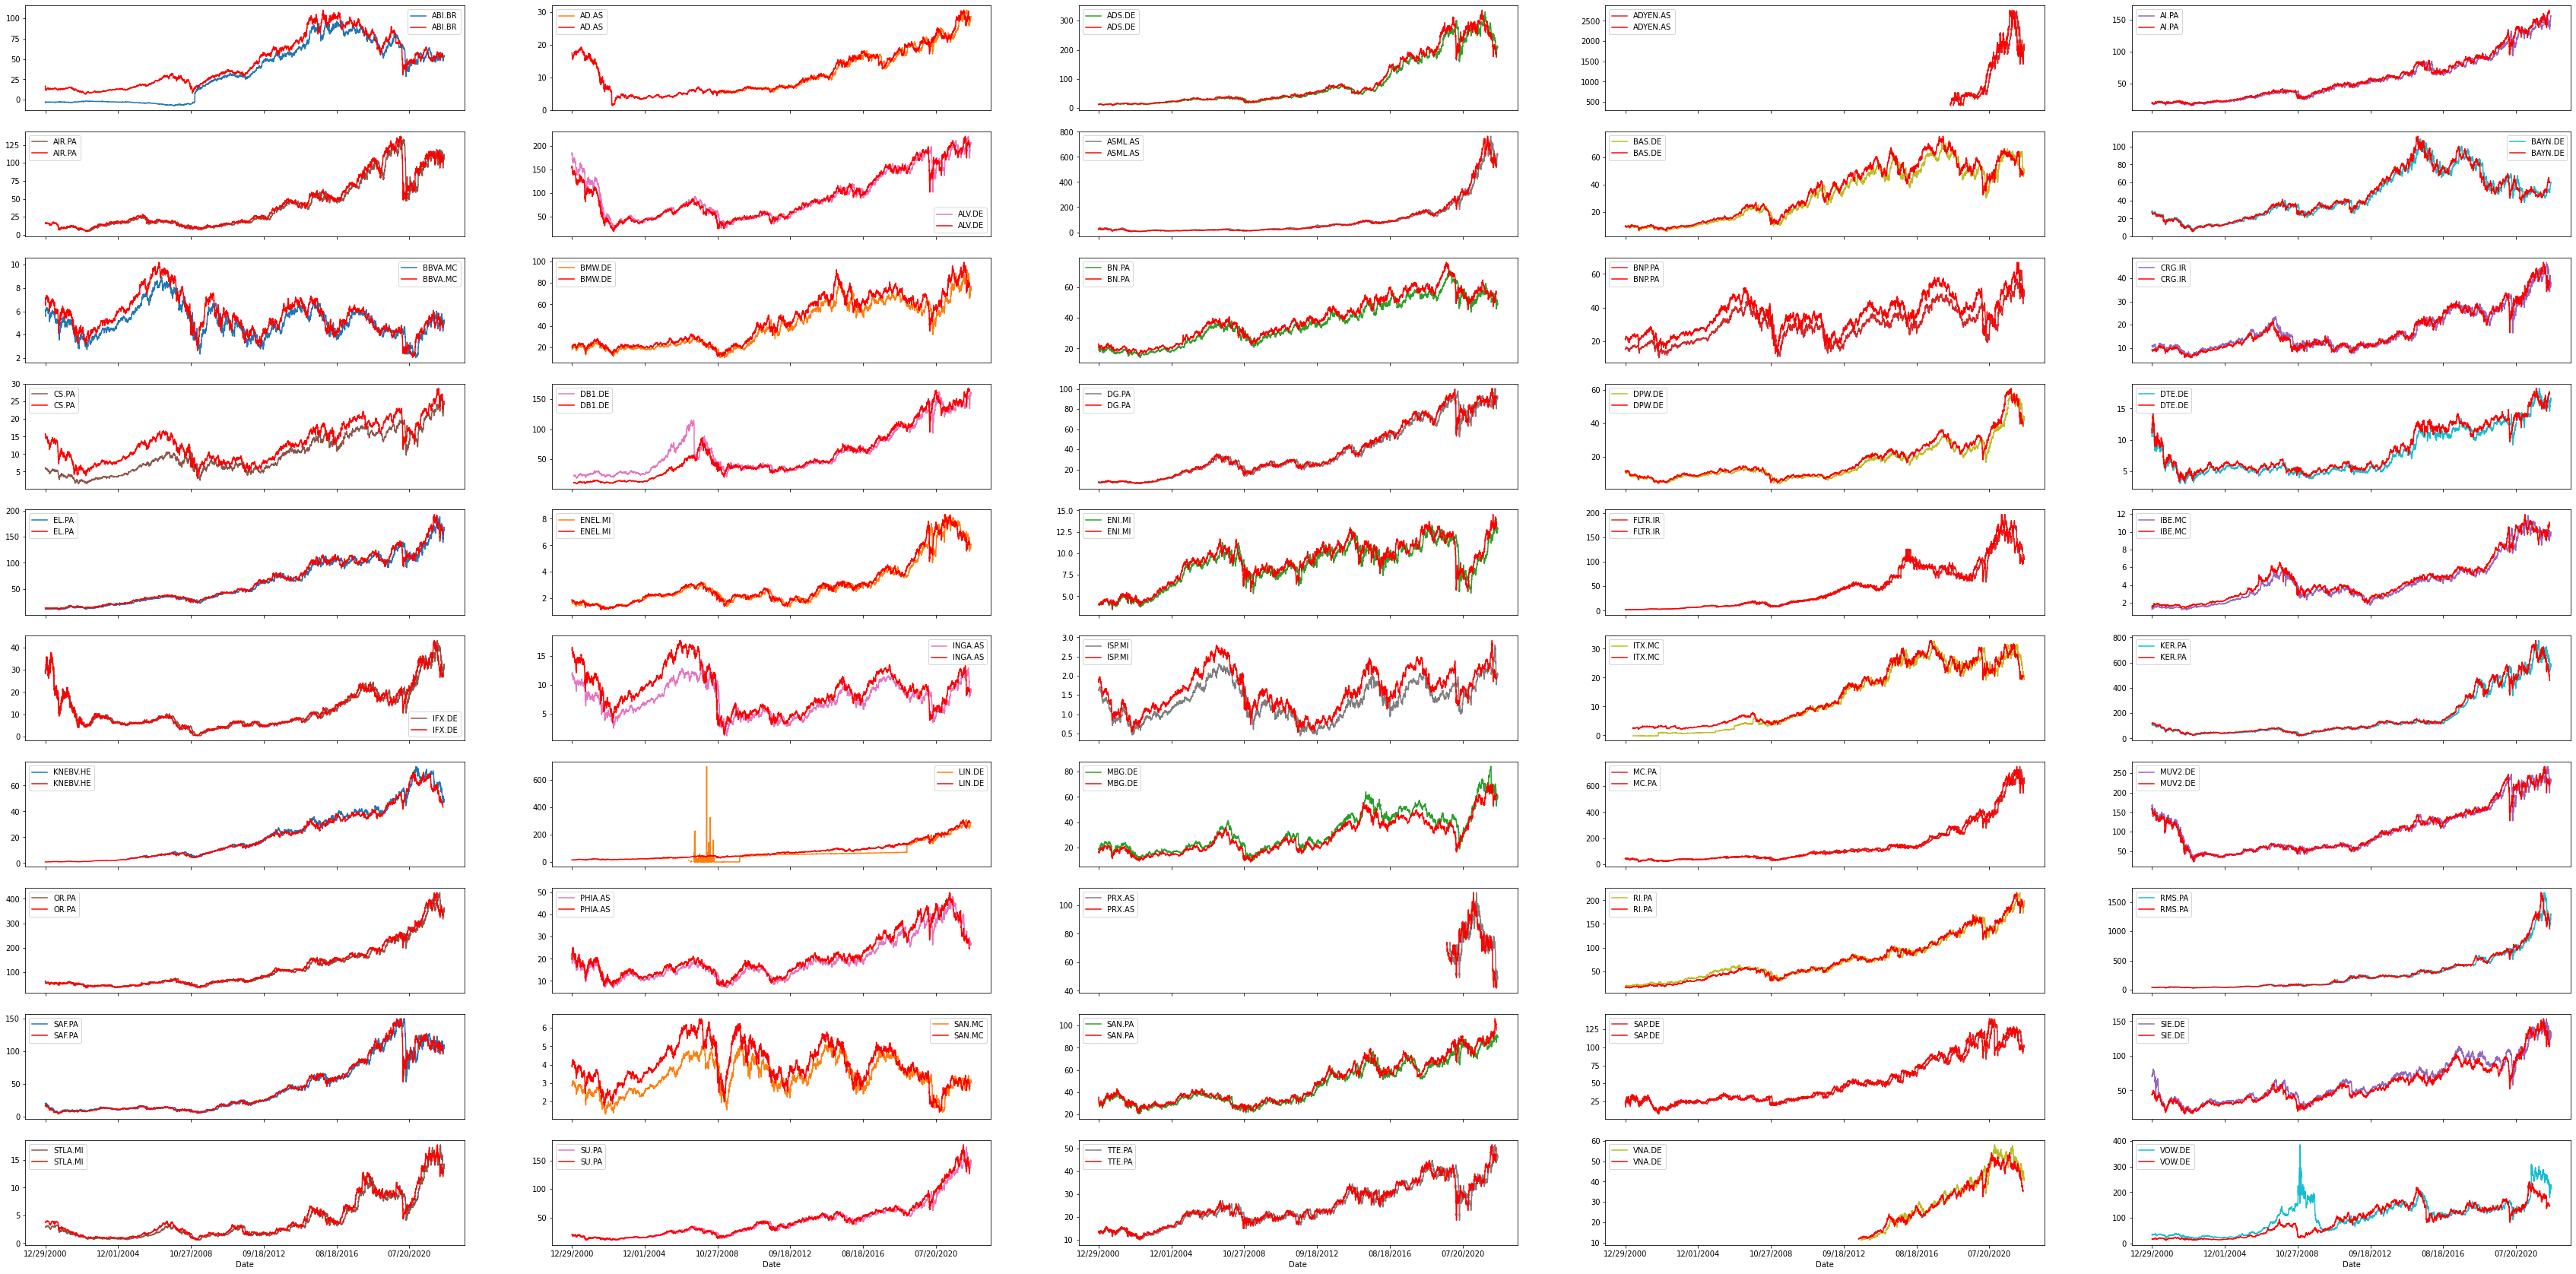

In [ ]:
ax = adjClose.plot(subplots=True,layout=(10,5),figsize=(60,30))
adjClose_fc.plot(subplots=True,color = 'red',layout=(10,5),figsize=(60,30),ax=ax)

Conclusion:<br>
YF,The unadjusted close (black line) is indeed higher, as it has not adjsuted for the didvidends. <br>
Factset adjusted close has more data available than YF, this could cause some shift in the price data and they will not totally overlap. YF data seems to be okay, Factset might seems to be a bit smoother, actual spike in the price has been taken out. For exmaple, LIN.DE and VOW.DE. However, the spike did did happen. So, using YFdata adjusted close for further modeling will be fine.